In [3]:
%matplotlib inline

import collections
import random
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sklearn.metrics
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Neural language models

Up to now we've always been classifying given sequences of texts.
In this topic, we'll see how to generate a sequence ourselves that will contain acceptable English text.

## Next token prediction

The basis of neural network sequence generation is the **next token prediction** task, that is, given a prefix of a text, determine which token can be the next token in the text.
For example, how likely is 'it' to come after 'I like'?
This is a basic classification task where the input is the prefix and the output is a softmax over the tokens in the vocabulary.

In order to be able to predict the first token, we'll add a new special token to our vocabulary called the **start token**.
The start token is added to the front of every text so that we can predict the first token in a text by asking what comes after the the start token.
Another important feature in next token prediction is the ability to predict that no token should come after a given prefix because the prefix makes a complete text.
To handle this case we'll add another control token to our vocabulary called the **end token**, which, when predicted, signals that the end of the text has been reached.
The end token is added to the end of every text.
In practice there is no reason for these two to be two separate tokens and we usually use one token for both called the **edge token**.

One way to predict the next token in a prefix is by having a data set that looks like this:

| prefix                        | next token|
|-------------------------------|-----------|
| `EDGE PAD PAD   PAD  PAD PAD` | `I`       |
| `EDGE I   PAD   PAD  PAD PAD` | `like`    |
| `EDGE I   like  PAD  PAD PAD` | `it`      |
| `EDGE I   like  it   PAD PAD` | `.`       |
| `EDGE I   like  it   .   PAD` | `EDGE`    |
| `EDGE PAD PAD   PAD  PAD PAD` | `I`       |
| `EDGE I   PAD   PAD  PAD PAD` | `don't`   |
| `EDGE I   don't PAD  PAD PAD` | `like`    |
| `EDGE I   don't like PAD PAD` | `it`      |
| `EDGE I   don't like it  PAD` | `.`       |
| `EDGE I   don't like it    .` | `EDGE`    |

But this will result in a lot of pad tokens which waste space and we don't actually need to learn to predict just one token in every row.
We can learn this task efficiently by taking advantage of the intermediate RNN states.
In the previous topic, we learned to make the same prediction for every prefix in a text.
Now we will predict the next token for every prefix in a text.
In this case, our data set will look like this:

| x                          | y                           |
|----------------------------|-----------------------------|
| `EDGE I like  it   .  PAD` | `I like  it   .  EDGE  PAD` |
| `EDGE I don't like it   .` | `I don't like it .    EDGE` |

What will happen here is that the RNN will generate a prefix vector for each prefix in the sequence in 'x' followed by a softmax layer applied to each prefix vector.
The target class for each prefix corresponds to the sequence in 'y'.
The 'y' column is saying what the next token should be for every corresponding token in 'x'.
For the first row, 'EDGE' corresponds to 'I', 'I' corresponds to 'like', and so on.
So the prefix vector generated from 'EDGE' will have the target class 'I', the prefix vector generated from 'EDGE I' will have the target class 'like', and so on.
This is much more efficient than the 'prefix - next token' data set, both in terms of space and training time.

Here is how to make this data set:

In [4]:
train_text_tokens = [
    'I like it .'.split(' '),
    'I hate it .'.split(' '),
    'I don\'t hate it .'.split(' '),
    'I don\'t like it .'.split(' '),
]

max_len = max(len(text) for text in train_text_tokens) + 1 # Including the edge token.
print('max_len:', max_len)

vocab = ['<PAD>', '<EDGE>'] + sorted({token for text in train_text_tokens for token in text})
token2index = {t: i for (i, t) in enumerate(vocab)}
pad_index = token2index['<PAD>']
edge_index = token2index['<EDGE>']
print('vocab:', vocab)
print('edge index:', edge_index)
print()

train_text_x_indexed_np = np.full((len(train_text_tokens), max_len), pad_index, np.int64)
for i in range(len(train_text_tokens)):
    train_text_x_indexed_np[i, 0] = edge_index # Add the edge token at the beginning.
    for j in range(len(train_text_tokens[i])):
        train_text_x_indexed_np[i, j + 1] = token2index[train_text_tokens[i][j]]
train_text_x_indexed = torch.tensor(train_text_x_indexed_np, device=device)
print('train_text_x_indexed (edge token at the beginning):')
print(train_text_x_indexed)
print()

train_text_y_indexed_np = np.full((len(train_text_tokens), max_len), pad_index, np.int64)
for i in range(len(train_text_tokens)):
    for j in range(len(train_text_tokens[i])):
        train_text_y_indexed_np[i, j] = token2index[train_text_tokens[i][j]]
    train_text_y_indexed_np[i, len(train_text_tokens[i])] = edge_index # Add the edge token at the end.
train_text_y_indexed = torch.tensor(train_text_y_indexed_np, device=device)
print('train_text_y_indexed (edge token at the end):')
print(train_text_y_indexed)

max_len: 6
vocab: ['<PAD>', '<EDGE>', '.', 'I', "don't", 'hate', 'it', 'like']
edge index: 1

train_text_x_indexed (edge token at the beginning):
tensor([[1, 3, 7, 6, 2, 0],
        [1, 3, 5, 6, 2, 0],
        [1, 3, 4, 5, 6, 2],
        [1, 3, 4, 7, 6, 2]], device='cuda:0')

train_text_y_indexed (edge token at the end):
tensor([[3, 7, 6, 2, 1, 0],
        [3, 5, 6, 2, 1, 0],
        [3, 4, 5, 6, 2, 1],
        [3, 4, 7, 6, 2, 1]], device='cuda:0')


We'll now train a neural network to predict the next token from every prefix.
Afterwards, we'll go through each unique prefix in the training set and show the softmax output of each possible token in the vocabulary being the next token in the prefix.

Note that when using `torch.nn.functional.cross_entropy` on 3D logits, as is the case here, the function expects the dimensions to be `(batch size, num classes, time steps)`.
Since our logits are `(batch size, time steps, num classes)`, we need to transpose dimensions 1 and 2 before passing them to the cross-entropy function.

epoch error
200 0.31368598341941833
400 0.2596908509731293
600 0.2559770941734314
800 0.25450924038887024
1000 0.2537882328033447
1200 0.2533169090747833
1400 0.25302961468696594
1600 0.2528192400932312
1800 0.2526983916759491
2000 0.25256654620170593
2200 0.252660870552063
2400 0.25241896510124207
2600 0.25236520171165466
2800 0.2523222267627716
3000 0.25228703022003174
3200 0.2522587478160858
3400 0.25224220752716064
3600 0.2529582977294922
3800 0.25219258666038513
4000 0.25217878818511963



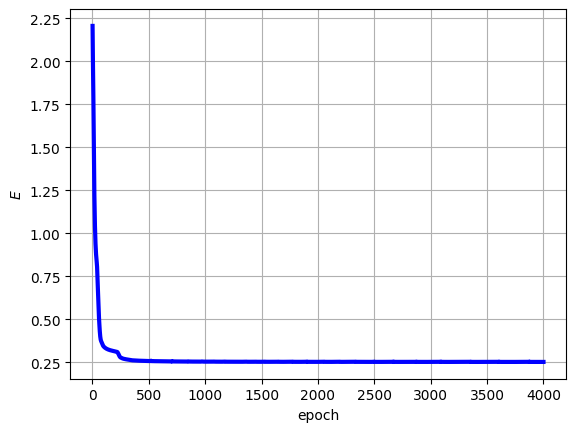

In [5]:
class Model(torch.nn.Module):

    def __init__(self, vocab_size, embedding_size, state_size):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        self.rnn_s0 = torch.nn.Parameter(torch.zeros((state_size,), dtype=torch.float32))
        self.rnn_c0 = torch.nn.Parameter(torch.zeros((state_size,), dtype=torch.float32))
        self.rnn_cell = torch.nn.LSTMCell(embedding_size, state_size)
        self.output_layer = torch.nn.Linear(state_size, vocab_size) # Output size is vocabulary size.

    def forward(self, text_x_indexed):
        batch_size = text_x_indexed.shape[0]
        time_steps = text_x_indexed.shape[1]

        embedded = self.embedding(text_x_indexed)
        state = self.rnn_s0[None, :].tile((batch_size, 1))
        c = self.rnn_c0[None, :].tile((batch_size, 1))
        interm_states_list = []
        for t in range(time_steps):
            (state, c) = self.rnn_cell(embedded[:, t, :], (state, c))
            interm_states_list.append(state)
        interm_states = torch.stack(interm_states_list, dim=1)
        return self.output_layer(interm_states)

model = Model(len(vocab), embedding_size=2, state_size=2)
model.to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.1)

print('epoch', 'error')
train_errors = []
for epoch in range(1, 4000+1):
    pad_mask = train_text_x_indexed == pad_index
    
    optimiser.zero_grad()
    logits = model(train_text_x_indexed)
    train_token_errors = torch.nn.functional.cross_entropy(logits.transpose(1, 2), train_text_y_indexed, reduction='none') # Transpose.
    train_token_errors = train_token_errors.masked_fill(pad_mask, 0.0)
    train_error = train_token_errors.sum()/(~pad_mask).sum()
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()

    if epoch%200 == 0:
        print(epoch, train_errors[-1])
print()

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

Now we need to extract all the unique prefixed from the texts and indexify them.

In [6]:
prefixes = sorted({tuple(text[:i]) for text in train_text_tokens for i in range(len(text) + 1)}) # Prefix must be a tuple so we can put it in a set.
prefix_max_len = max(len(prefix) for prefix in prefixes) + 1
prefix_text_x_indexed_np = np.full((len(prefixes), prefix_max_len), pad_index, np.int64)
for i in range(len(prefixes)):
    prefix_text_x_indexed_np[i, 0] = edge_index
    for j in range(len(prefixes[i])):
        prefix_text_x_indexed_np[i, j+1] = token2index[prefixes[i][j]]
prefix_text_x_indexed = torch.tensor(prefix_text_x_indexed_np, device=device)
with torch.no_grad():
    output = torch.softmax(model(prefix_text_x_indexed), dim=2).cpu().tolist()

`output` is a 3D tensor with a prediction over the whole vocabulary, for every token in every text.
We only want the predictions on the last token so that we can predict the next token after it.
Since the prefix starts with an edge token, the index of the last token is `len(prefix)` rather than `len(prefix)-1`.
Here we'll print the top 5 next tokens for every prefix.

In [7]:
for (prefix, y) in zip(prefixes, output):
    last_token_y = y[len(prefix)]
    top_preds = sorted(zip(last_token_y, vocab), reverse=True)[:5]
    print(['<EDGE>'] + list(prefix))
    for (x, token) in top_preds:
        print(f'   {token:6s}: {x:.8f}')
    print()

['<EDGE>']
   I     : 0.99990225
   it    : 0.00005834
   hate  : 0.00002253
   like  : 0.00001682
   don't : 0.00000001

['<EDGE>', 'I']
   don't : 0.49980861
   like  : 0.25005248
   hate  : 0.25004482
   .     : 0.00006885
   it    : 0.00002454

['<EDGE>', 'I', "don't"]
   like  : 0.49991548
   hate  : 0.49985737
   don't : 0.00018412
   I     : 0.00004304
   it    : 0.00000000

['<EDGE>', 'I', "don't", 'hate']
   it    : 0.99982423
   <EDGE>: 0.00008438
   I     : 0.00007792
   don't : 0.00001099
   <PAD> : 0.00000101

['<EDGE>', 'I', "don't", 'hate', 'it']
   .     : 0.99989533
   don't : 0.00008289
   <EDGE>: 0.00002171
   it    : 0.00000007
   <PAD> : 0.00000000

['<EDGE>', 'I', "don't", 'hate', 'it', '.']
   <EDGE>: 0.99989903
   it    : 0.00006367
   .     : 0.00003729
   <PAD> : 0.00000000
   don't : 0.00000000

['<EDGE>', 'I', "don't", 'like']
   it    : 0.99982041
   <EDGE>: 0.00010519
   I     : 0.00006176
   don't : 0.00001040
   <PAD> : 0.00000101

['<EDGE>', 'I', "don't

Note how the softmax output of the next token after '\<EDGE> I' is evenly split between 'like' and 'hate'.
This is for the same reason we saw in the previous topic when we were classifying prefixes according to the sentiment of the whole text they are in.
The prefix 'I' was half of the time in a positive text and half of the time in a negative text, so the neural network learned to output 0.5 instead of 1 or 0.
Here the neural network has also learned to split the output between all the right answers.
In fact, we can stop thinking of the outputs as classifying the next token and start thinking of them as the probability of each token being the next token.
These probabilities will be the basis for our language models and for generating text.

Note also that we're doing something called **self-supervised learning** here, that is, we're training the neural network to predict the input itself rather than some label about the input.
Self-supervised learning tasks have the advantage that you only need to collect free text as data, without needing to label it.

## Language modelling

The next word prediction model is also known as a **neural language model**.
A language model is a model that calculates the probability of a text in a certain language domain (the kind of language used in the training set).
The probability returned by the language model should estimate how plausible a text is.
For example, we'd expect that the sentence "The dog bit the cat." to have a higher probability than "The chair bit the cat." which would in turn have a higher probability than "The the the the.".

To understand how to calculate the probability of a text, we need to understand some conditional probability theory.
Say we have the Venn diagram below consisting of a set of even numbers and a set of square numbers, with some numbers intersecting both.

![](conditional_prob.png)

There are 10 different numbers in all, 4 in the square set, 8 in the even set, and 2 shared between both.
Therefore, the probability of randomly selecting a square number out of all 10 numbers is $\frac{4}{10}$, the probability of selecting an even number is $\frac{8}{10}$, and the probability of selecting a number that is both square and even is $\frac{2}{10}$.
These are **unconditional probabilities**, because they are based on the entire set of numbers.
They are expressed as $P(square)$, $P(even)$, and $P(square, even)$.
This last probability is called a **joint probability**.

An example of a **conditional probability** would be the probability of selecting a square number, given that it is also an even number.
This is giving extra information that narrows down the possible choices, resulting in a larger probability.
In this case, the probability of selecting a square number given that it is also even is $\frac{2}{8}$.
This probability is expressed as $P(square|even)$, that is, "the probability of square, given even".

Mathematically, a conditional probability is defined as:

$$P(A|B) = \frac{P(A, B)}{P(B)}$$

or equivalently,

$$P(A, B) = P(A|B) P(B)$$

This gives us a way to **decompose** complex joint probabilities, which we'll be using for language models.

Back to text and language models.

The probability of a text is expressed as:

$$P(t_1, t_2, \dots, t_n)$$

This is read as the joint probability of token 1, token 2, and so on up to the last token.
Now the problem with this is that language models don't calculate this directly.
Instead, they calculate a conditional probability: the probability of a token given a prefix of tokens preceeding it.

$$P(t_n | t_1, t_2, \dots, t_{n-1})$$

We can convert the joint probability into many conditional probabilities like this by repeatedly decomposing it.
The joint probability can be decomposed using conditional probabilities:

$P(t_1, t_2, \dots, t_n) = P(t_1) \times P(t_2, t_3, \dots, t_n | t_1)$

which is saying that the joint probability of all the tokens is equal to the probability of the first token multiplied by the probability of the rest of the tokens given the first token (as a prefix).
We can then decompose the second part again:

$P(t_2, t_3, \dots, t_n | t_1) = P(t_2 | t_1) \times P(t_3, t_4 \dots, t_n | t_1, t_2)$

The probability $P(t_2 | t_1)$ means the probability that the next token is $t_2$ given that the prefix is $t_1$, which is what our next token prediction neural network computes!
We can keep decomposing until we get the following:

$P(t_1, t_2, \dots, t_n) = P(t_1) \times P(t_2 | t_1) \times P(t_3 | t_1, t_2) \times \dots \times P(t_n | t_1, t_2, \dots, t_{n-1})$

So we'll end up with the following probabilities that need to be multiplied together:

* the probability of the first token by
* the probability of the second token following the first token by
* the probability of the third token following the first and second tokens by
* ...
* the probability of the last token following the first up to the second to last token.

We can use the neural network to calculate all of these probabilities except for the first one.
But the first token is the edge token, which we know has a probability of 100% of being the first token, because we make sure that it is always at the beginning of every text.
So we can ignore this probability because we'd just be multiplying by 1.

Therefore, the probability of the sentence "I like it." is calculated as:

$P(\text{I} | \text{EDGE}) \times P(\text{like} | \text{EDGE I}) \times P(\text{it} | \text{EDGE I like}) \times P(\text{.} | \text{EDGE I like it}) \times P(\text{EDGE} | \text{EDGE I like it .})$

So we just need to get the probabilities of each token in the text given its prefix, which can be easily calculated using the next token prediction model.

In [8]:
print('prefixes:')
print(train_text_x_indexed)
print()

print('next tokens:')
print(train_text_y_indexed)
print()

output = torch.softmax(model(train_text_x_indexed), dim=2)
print('probability of every token in the vocabulary being the next token in every prefix')
print(output)

prefixes:
tensor([[1, 3, 7, 6, 2, 0],
        [1, 3, 5, 6, 2, 0],
        [1, 3, 4, 5, 6, 2],
        [1, 3, 4, 7, 6, 2]], device='cuda:0')

next tokens:
tensor([[3, 7, 6, 2, 1, 0],
        [3, 5, 6, 2, 1, 0],
        [3, 4, 5, 6, 2, 1],
        [3, 4, 7, 6, 2, 1]], device='cuda:0')

probability of every token in the vocabulary being the next token in every prefix
tensor([[[1.5700e-11, 5.2787e-17, 8.0005e-20, 9.9990e-01, 1.2721e-08,
          2.2534e-05, 5.8340e-05, 1.6823e-05],
         [4.8782e-07, 2.7149e-10, 6.8849e-05, 1.1196e-07, 4.9981e-01,
          2.5004e-01, 2.4536e-05, 2.5005e-01],
         [9.8629e-07, 7.2571e-05, 1.8169e-08, 9.1097e-05, 1.1067e-05,
          9.1128e-07, 9.9982e-01, 6.8019e-07],
         [4.6111e-09, 2.1730e-05, 9.9990e-01, 4.8511e-18, 8.2945e-05,
          3.3849e-09, 6.8333e-08, 3.3841e-09],
         [2.4652e-10, 9.9990e-01, 3.7292e-05, 1.0911e-17, 3.0251e-11,
          6.7203e-17, 6.3673e-05, 5.0148e-17],
         [1.7285e-08, 6.7545e-01, 3.2450e-01, 1.

Now we're not interested in the probability of every possible token in the vocabulary for every token position in `train_text_x_indexed`.
What we want are the probabilities of the correct next token according to `train_text_y_indexed` only.
So we somehow need to select the needed number in every vector of `output` for every vector of probabilities it contains.
We need something like this:

In [9]:
print('first vector of outputs:')
print(output[0, 0, :])
print()
print('index to extract from here:')
print(train_text_y_indexed[0, 0])
print()
print('selected probability:')
print(output[0, 0, train_text_y_indexed[0, 0]])
print()
print()

print('second vector of outputs:')
print(output[0, 1, :])
print()
print('index to extract from here:')
print(train_text_y_indexed[0, 1])
print()
print('selected probability:')
print(output[0, 1, train_text_y_indexed[0, 1]])

first vector of outputs:
tensor([1.5700e-11, 5.2787e-17, 8.0005e-20, 9.9990e-01, 1.2721e-08, 2.2534e-05,
        5.8340e-05, 1.6823e-05], device='cuda:0', grad_fn=<SliceBackward0>)

index to extract from here:
tensor(3, device='cuda:0')

selected probability:
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward0>)


second vector of outputs:
tensor([4.8782e-07, 2.7149e-10, 6.8849e-05, 1.1196e-07, 4.9981e-01, 2.5004e-01,
        2.4536e-05, 2.5005e-01], device='cuda:0', grad_fn=<SliceBackward0>)

index to extract from here:
tensor(7, device='cuda:0')

selected probability:
tensor(0.2501, device='cuda:0', grad_fn=<SelectBackward0>)


So we need to extract a different index from every vector in the 3D tensor `outputs`.
This is a complex selection mode that cannot be done using normal square bracket indexing.
We need to use the `gather` function.

In [10]:
tensor  = torch.tensor([[0, 1], [2, 3], [4, 5]], dtype=torch.int64, device=device)
indexes = torch.tensor([[ 0  ], [ 1  ], [ 0  ]], dtype=torch.int64, device=device)
print(tensor.gather(1, indexes))

tensor([[0],
        [3],
        [4]], device='cuda:0')


In the above example, we're selecting index 0 from the first vector, index 1 from the second vector, and index 0 from the third vector.

We'll explain this function in the way that is relevant to our needs, as `gather` can actually do more than what is explained below.
`gather` takes a dimension and a tensor of indexes.
The dimension says where to find the vectors to work on in the tensor.
Since we want to select from the row vectors of the matrix, we specify dimension 1 (the rows).
The indexes are a row-by-row specification of which element to extract from each vector.
It must have the same shape as the tensor so that the indexes can be matched with the vectors.

In our case, we have a 3D tensor (`outputs`) and 2D indexes (`train_text_y_indexed`).
The vectors in `outputs` are found in dimension 2 and we need to add a singleton dimension at the end of `train_text_y_indexed` to make it compatible.

In [11]:
token_probs = output.gather(2, train_text_y_indexed[:, :, None])[:, :, 0]
print('probability of the tokens in y being the next token in every prefix')
print(token_probs)

probability of the tokens in y being the next token in every prefix
tensor([[9.9990e-01, 2.5005e-01, 9.9982e-01, 9.9990e-01, 9.9990e-01, 1.7285e-08],
        [9.9990e-01, 2.5004e-01, 9.9982e-01, 9.9990e-01, 9.9990e-01, 1.7298e-08],
        [9.9990e-01, 4.9981e-01, 4.9986e-01, 9.9982e-01, 9.9990e-01, 9.9990e-01],
        [9.9990e-01, 4.9981e-01, 4.9992e-01, 9.9982e-01, 9.9990e-01, 9.9990e-01]],
       device='cuda:0', grad_fn=<SelectBackward0>)


All of these probabilities are each of those $P(t_n | t_1, t_2, \dots, t_{n-1})$ factors that need to be multiplied together.
Of course there's a matrix of these because each row belongs to a different text, so we should only multiply together the probabilities in the rows.
We still need to get rid of the pad tokens, which we need to replace with 1, since they're being multiplied together.

In [12]:
token_probs = token_probs.masked_fill(pad_mask, 1.0)
print('masked token probabilities:')
print(token_probs)
print()

text_probs = token_probs.prod(dim=1)
print('probability of whole texts:')
print(text_probs)

masked token probabilities:
tensor([[0.9999, 0.2501, 0.9998, 0.9999, 0.9999, 1.0000],
        [0.9999, 0.2500, 0.9998, 0.9999, 0.9999, 1.0000],
        [0.9999, 0.4998, 0.4999, 0.9998, 0.9999, 0.9999],
        [0.9999, 0.4998, 0.4999, 0.9998, 0.9999, 0.9999]], device='cuda:0',
       grad_fn=<MaskedFillBackward0>)

probability of whole texts:
tensor([0.2499, 0.2499, 0.2497, 0.2497], device='cuda:0',
       grad_fn=<ProdBackward1>)


Note how each text has a probability of approximately 25%, which is because we overfitted the language model on the training set and it now thinks that those four texts are the only texts that could ever exist.

Multiplying a bunch of probabilities together can result in a number that is too small to do anything with (or it gets rounded down to zero).
This problem is usually avoided by using logarithmic probabilities.
Logarithms of probabilities are larger and more easily usable than the probabilities themselves.

An important change with logarithmic probabilities is that multiplying probabilities together is replaced with adding logarithmic probabilities together:

$\log(p_1 \times p_2 \times \dots \times p_n) = \log(p_1) + \log(p_2) + \dots + \log(p_n)$

Therefore,

$\log P(\text{I like it . EDGE}) = \log P(\text{I} | \text{EDGE}) + \log P(\text{like} | \text{EDGE I}) + \log P(\text{it} | \text{EDGE I like}) + \log P(\text{.} | \text{EDGE I like it}) + \log P(\text{EDGE} | \text{EDGE I like it .})$

You can then remove the logarithm by exponentiating it:

$P(\text{I like it .}) = e^{\log P(\text{I like it .})}$

If you just want to sort your sentences by probability, you can just work with the logarithmic probabilities directly without converting them into actual probabilities because the largest logarithmic probabilities is also the largest probability.

The use of logarithmic probabilities is such a common practice that PyTorch provides a log softmax function which immediately calculates the log of probabilities from logits: `torch.log_softmax`.

Here is the complete code for getting both the logarithmic probabilities and the probabilities of texts using a language model:

In [13]:
with torch.no_grad():
    output = torch.log_softmax(model(train_text_x_indexed), dim=2)
    token_log_probs = output.gather(2, train_text_y_indexed[:, :, None])[:, :, 0]
    token_log_probs = token_log_probs.masked_fill(pad_mask, 0.0)
    text_log_probs = token_log_probs.sum(dim=1).cpu().tolist()

for (text, log_prob) in zip(train_text_tokens, text_log_probs):
    print(f'{text}: {np.exp(log_prob):.5f} ({log_prob:.5f})')

['I', 'like', 'it', '.']: 0.24993 (-1.38657)
['I', 'hate', 'it', '.']: 0.24992 (-1.38660)
['I', "don't", 'hate', 'it', '.']: 0.24971 (-1.38744)
['I', "don't", 'like', 'it', '.']: 0.24974 (-1.38733)


### Evaluating language models

This brings us to how to evaluate a language model.
A good language model is one that always gives a high probability to the correct next token.
The standard way this is measured is using the **perplexity measure** (**pplx**):

$\text{pplx}(s) = e^{-\frac{1}{|T|} \log{P(T)}}$

where $T$ is a text and $|T|$ is the number of tokens in the sentence.
The text is usually not from the training set in order to check for overfitting.
What this function measures is the average perplexity (confusion) that the model experiences when trying to guess the next word in every prefix in the sentence.
If you get a perplexity of 50, that means that, on average, the model was as perplexed as having to pick the correct item out of 50.
The smaller the perplexity, the better the language model, because it could confidently guess the words in the sentence.
A perfect language model (which is impossible on a non-trivial test set) would have a perplexity of 1.

It is also just $e$ to the power of the cross-entropy of a language model on a text.
In fact we can calculate it very easily by just using `torch.nn.functional.cross_entropy`, without having to use `gather` or `log_softmax`.
Just be sure to mask out the pad tokens as usual.

Below we're finding the perplexity of the language model with respect to the whole training set:

In [14]:
with torch.no_grad():
    logits = model(train_text_x_indexed)
    train_token_xes = torch.nn.functional.cross_entropy(logits.transpose(1, 2), train_text_y_indexed, reduction='none')
    train_token_xes = train_token_xes.masked_fill(pad_mask, 0.0)
    train_xe = train_token_xes.sum()/(~pad_mask).sum()
    pplx = torch.exp(train_xe).cpu().tolist()
print('pplx:', pplx)

pplx: 1.2868258953094482


## Token sampling

We have seen how to guess the next item in a sequence and how to compute the probability of a sequence, but you were promised that we'd be generating sequences in this topic.
This can be easily made using the probabilities of all tokens being the next token in a prefix.

The idea is to start from a prefix consisting of just the edge token and iteratively add more tokens to the prefix until we have a complete text as a prefix.
The tokens chosen to be the next token in the prefix will be chosen randomly based on their probabilities.
This is called **sampling** tokens.
So the more probable a token is to be the next token, the more likely it will be chosen as the next token.
This can easily be done using the `random.choices` function:

In [15]:
for _ in range(20):
    print(random.choices([10, 20, 30], [0.1, 0.1, 0.8])[0])

30
30
20
30
30
30
10
30
30
30
30
30
10
30
30
30
10
20
10
10


We can keep on adding tokens to our prefix until the edge token is chosen, or until some maximum number of tokens is reached.

We'll create a fixed tensor for the prefix that is as long as the maximum number of tokens to generate.
It will start containing only the edge token and the rest is filled with pad tokens.
We'll then iteratively predict the next token from the non-pad tokens in the tensor and add it to the prefix.

In [16]:
def sample_generate(model, vocab, edge_index, pad_index, max_len):
    prefix_indexed = torch.tensor([[edge_index] + [pad_index]*max_len], dtype=torch.int64, device=device) # Initialise the prefix to just the edge token followed by pad tokens. It's faster to update a single element in a tensor than to recreate a whole new one.
    prefix_prob = 1.0
    prefix_len = 1
    with torch.no_grad():
        for i in range(max_len):
            outputs = torch.softmax(model(prefix_indexed[:, :i+1]), dim=2)
            token_probs = outputs[0, -1, :].cpu().tolist() # Get the probabilities of each token in the vocabulary being the next token in the prefix.
            next_token_index = random.choices(range(len(vocab)), token_probs)[0] # Randomly choose a token according to its probability.
            prefix_indexed[0, i+1] = next_token_index # Put this token in the prefix.
            prefix_prob *= token_probs[next_token_index] # Update the probability of the prefix.
            prefix_len += 1
            if next_token_index == edge_index: # Stop selecting tokens when the edge token is selected.
                break
    text = [vocab[index] for index in prefix_indexed[0, :prefix_len].cpu().tolist()] # Convert the indexes in the prefix to string tokens.
    return (text, prefix_prob)

(text, text_prob) = sample_generate(model, vocab, edge_index, pad_index, max_len=10)
print(text, f'(p={text_prob:.3f})')

['<EDGE>', 'I', 'like', 'it', '.', '<EDGE>'] (p=0.250)


Rather than recreating a new prefix tensor every time a new token is selected, a maximum length prefix tensor is created at the start and is then updated with new tokens one token position at a time.
This is faster.

Note that we usually don't include the unknown token with the generated tokens as it is not a real word.
Thankfully `random.choices` does not expect the probabilities to add up to 1 as it normalises the numbers so that they add up to 1 prior to using them.
With this in mind, we can avoid generating unknown tokens by replacing the probability of the unknown token with 0.0 so that it would never be chosen, as shown below:

In [17]:
def sample_generate_no_unk(model, vocab, edge_index, pad_index, unk_index, max_len):
    prefix_indexed = torch.tensor([[edge_index] + [pad_index]*max_len], dtype=torch.int64, device=device)
    prefix_prob = 1.0
    prefix_len = 1
    with torch.no_grad():
        for i in range(max_len):
            outputs = torch.softmax(model(prefix_indexed[:, :i+1]), dim=2)
            token_probs = outputs[0, -1, :].cpu().tolist()
            token_probs[unk_index] = 0.0 # Replace the probability of the unknown token with 0.0.
            next_token_index = random.choices(range(len(vocab)), token_probs)[0]
            prefix_indexed[0, i+1] = next_token_index
            prefix_prob *= token_probs[next_token_index]
            prefix_len += 1
            if next_token_index == edge_index:
                break
    text = [vocab[index] for index in prefix_indexed[0, :prefix_len].cpu().tolist()]
    return (text, prefix_prob)

## Exercises

### 1) Write a movie review

Train a language model on the texts in the movie review data set.
Preprocessing has been done for you.

Measure the perplexity of the language model on the test set.
Also generate a 3 random reviews from the trained language model.

Note that language model training is considerably slow compared to classification, mostly due to the huge softmax.
Note also that if you haven't been using batching up to now, you might need to use it now as language models use a considerable amount of memory.

In [18]:
min_freq = 3

train_df = pd.read_csv('../data_set/sentiment/train.csv')
test_df = pd.read_csv('../data_set/sentiment/test.csv')

train_text = train_df['text']
test_text = test_df['text']

nltk.download('punkt')
train_text_tokens = [nltk.word_tokenize(text) for text in train_text]
test_text_tokens = [nltk.word_tokenize(text) for text in test_text]
max_len = max(max(len(text) for text in train_text_tokens), max(len(text) for text in test_text_tokens)) + 1

frequencies = collections.Counter(token for text in train_text_tokens for token in text)
vocabulary = sorted(frequencies.keys(), key=frequencies.get, reverse=True)
while frequencies[vocabulary[-1]] < min_freq:
    vocabulary.pop()
vocab = ['<PAD>', '<EDGE>', '<UNK>'] + vocabulary
token2index = {token: i for (i, token) in enumerate(vocab)}
pad_index = token2index['<PAD>']
edge_index = token2index['<EDGE>']
unk_index = token2index['<UNK>']

train_text_x_indexed_np = np.full((len(train_text_tokens), max_len), pad_index, np.int64)
for i in range(len(train_text_tokens)):
    train_text_x_indexed_np[i, 0] = edge_index
    for j in range(len(train_text_tokens[i])):
        train_text_x_indexed_np[i, j + 1] = token2index.get(train_text_tokens[i][j], unk_index)
train_text_x_indexed = torch.tensor(train_text_x_indexed_np, device=device)

train_text_y_indexed_np = np.full((len(train_text_tokens), max_len), pad_index, np.int64)
for i in range(len(train_text_tokens)):
    for j in range(len(train_text_tokens[i])):
        train_text_y_indexed_np[i, j] = token2index.get(train_text_tokens[i][j], unk_index)
    train_text_y_indexed_np[i, len(train_text_tokens[i])] = edge_index
train_text_y_indexed = torch.tensor(train_text_y_indexed_np, device=device)

test_text_x_indexed_np = np.full((len(test_text_tokens), max_len), pad_index, np.int64)
for i in range(len(test_text_tokens)):
    test_text_x_indexed_np[i, 0] = edge_index
    for j in range(len(test_text_tokens[i])):
        test_text_x_indexed_np[i, j + 1] = token2index.get(test_text_tokens[i][j], unk_index)
test_text_x_indexed = torch.tensor(test_text_x_indexed_np, device=device)

test_text_y_indexed_np = np.full((len(test_text_tokens), max_len), pad_index, np.int64)
for i in range(len(test_text_tokens)):
    for j in range(len(test_text_tokens[i])):
        test_text_y_indexed_np[i, j] = token2index.get(test_text_tokens[i][j], unk_index)
    test_text_y_indexed_np[i, len(test_text_tokens[i])] = edge_index
test_text_y_indexed = torch.tensor(test_text_y_indexed_np, device=device)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
